In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import models_RHUnet

In [2]:
# Importing raw data
file_t = 'GSH_example_850_24_tri_abs.txt'  
f = open(file_t,"r")  
string = f.readlines()     
data_list = []  
for i in string:
    if i[0] != '#':
        data_list.append(float(i))
si = len(data_list)  
low = float(string[3][string[3].index('LEFT =')+7:string[3].index('RIGHT = ')-6])
high = float(string[3][string[3].index('RIGHT =')+8:-6])
ppm = np.linspace(low , high, si )
o1p = np.round((low+high)/2, 3)
sw = np.round(low-high, 3)
print('size of the spectrum, si : {}'.format(si))
print('spectrum width, sw : {:.3f} ppm, o1p:{:.3f} ppm'.format(sw, o1p))

size of the spectrum, si : 32768
spectrum width, sw : 15.979 ppm, o1p:4.772 ppm


In [3]:
# Determine the position of internal standards
for count,i in enumerate(ppm):
    if i <  0:
        print(i, count)
        break
DSS_position = count

-0.0004058591930498068 26170


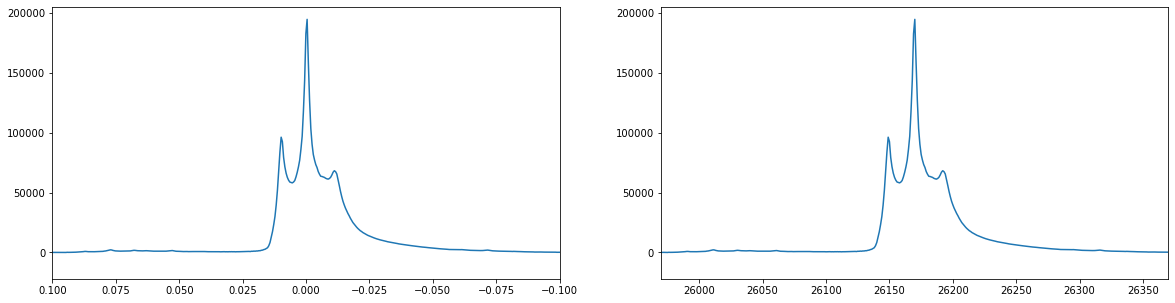

In [4]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(ppm, np.array(data_list))
plt.xlim(0.1, -0.1)
plt.subplot(1,2,2)
plt.plot( np.array(data_list))
plt.xlim(DSS_position-200, DSS_position+200)
plt.show()

[26149 26170 26192] {'peak_heights': array([0.49449325, 1.        , 0.35062111])}


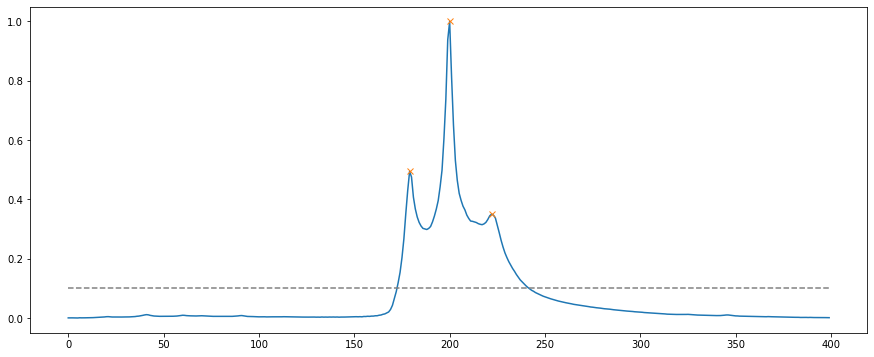

In [5]:
# Identifying Peaks
from scipy.signal import find_peaks
data_raw = np.array(data_list)/np.array(data_list[DSS_position-200:DSS_position+200]).max()
plt.figure(figsize= (15,6))
height = 0.1 
peaks, _ = find_peaks(data_raw[DSS_position-200:DSS_position+200], height=height)   
plt.plot(data_raw[DSS_position-200:DSS_position+200])
plt.plot(peaks, data_raw[DSS_position-200:DSS_position+200][peaks], "x")
plt.plot(np.zeros_like(data_raw[DSS_position-200:DSS_position+200]) + height, "--", color="gray")
print(peaks+DSS_position-200, _)
plt.show()

In [6]:
# Identifying Peaks position
heights = _['peak_heights']
k = 2  
b = heights.argsort()[-2:]
print(b, peaks[b], heights[b])
ref_peak_pos1 = peaks[b][0] + DSS_position-200
ref_peak_pos2 = peaks[b][1] + DSS_position-200
ref_peak_pos_list = [ref_peak_pos1, ref_peak_pos2]
print(ref_peak_pos_list)

[0 1] [179 200] [0.49449325 1.        ]
[26149, 26170]


In [7]:
# Calculating T2 Value, reset the B0 
def cal_t2(B0, pi = np.pi, hw = 1.5):
    return np.round((B0*sw)/(hw*pi*si), 4)
T2 = cal_t2(850, hw = 1.5)
print(T2)

0.088


In [8]:
# Defining Lorentzian Line Shape
exp = np.exp
pi = np.pi
t32 = np.linspace(0, 1, si )
def per_data(f, t=t32):
    fid = 1*exp(1j*2*pi*(f)*t)*exp(-t/T2)
    return np.fft.fft(fid).real/np.fft.fft(fid).real.max()
per_data1 = per_data(ref_peak_pos1)
per_data2 = per_data(ref_peak_pos2)

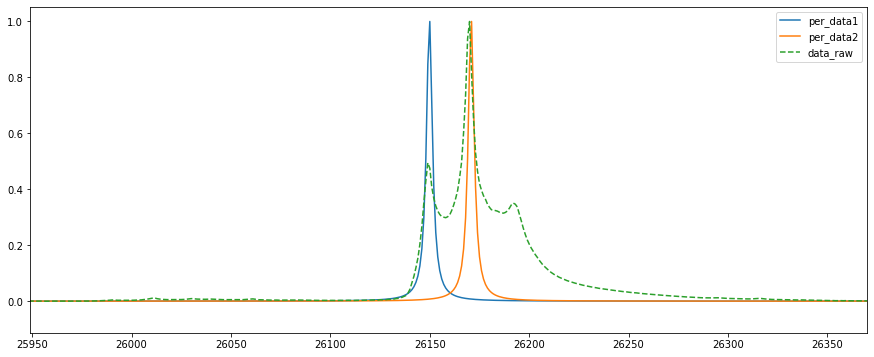

In [9]:
plt.figure(figsize= (15,6))
plt.plot(per_data1, label = 'per_data1')
plt.plot(per_data2, label = 'per_data2')
plt.plot(data_raw/data_raw[DSS_position-200:DSS_position+200].max(), linestyle = '--',label = 'data_raw')
plt.legend()
plt.xlim(ref_peak_pos1-200, ref_peak_pos2+200)
plt.show()

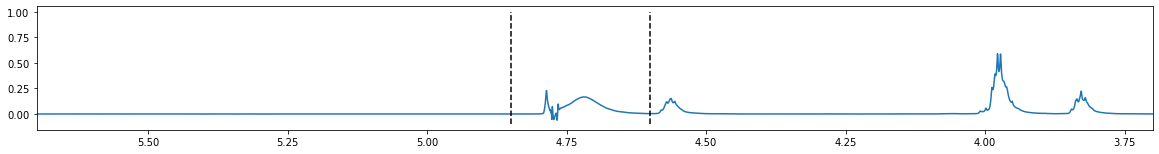

In [10]:
# Defining water peak region in ppm
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(ppm, data_raw)
plt.vlines([4.7+0.15, 4.7-0.1], -0.1, 1, linestyles='dashed', colors='k')
plt.xlim(4.7+1 , 4.7-1 )    
plt.show()

In [11]:
# Defining water peak region in pixel
water_position = []
for t_p in [4.7+0.15, 4.7-0.1]:
    for count, i in enumerate(ppm):
        if i <  t_p: 
            print(i, count)
            water_position.append(count)
            break
print('water region in position :{}'.format(water_position))

4.849801219216812 16224
4.599634696873734 16737
water region in position :[16224, 16737]


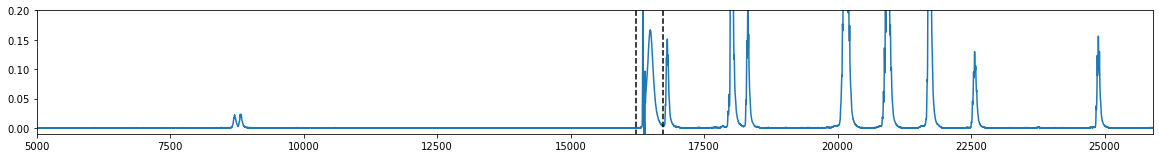

In [12]:
# Defining water peak region in pixel
plt.figure(figsize=(20,5))
plt.ylim(-0.01,0.4)
plt.subplot(2,1,2)
plt.plot(data_raw )
plt.vlines(water_position, -0.1, 1, linestyles='dashed', colors='k')
plt.xlim(5000, 25900 )
plt.ylim(-0.01,0.2)
plt.show()

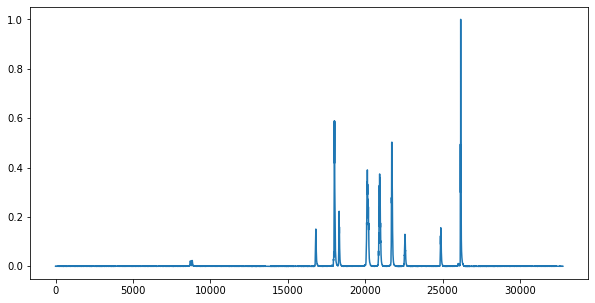

In [13]:
# remove water peak
water_down, water_up = water_position
data_raw[water_down: water_up] = data_raw[27000: 27000 - water_down+water_up] 
plt.figure(figsize=(10,5))
plt.plot(data_raw)
plt.show()

In [14]:
# Data Normalization
print(data_raw.min(), data_raw.max())
down = data_raw.min()  
data_raw -=  down
print(data_raw.min(), data_raw.max())

-0.0007145324185871845 1.0
0.0 1.000714532418587


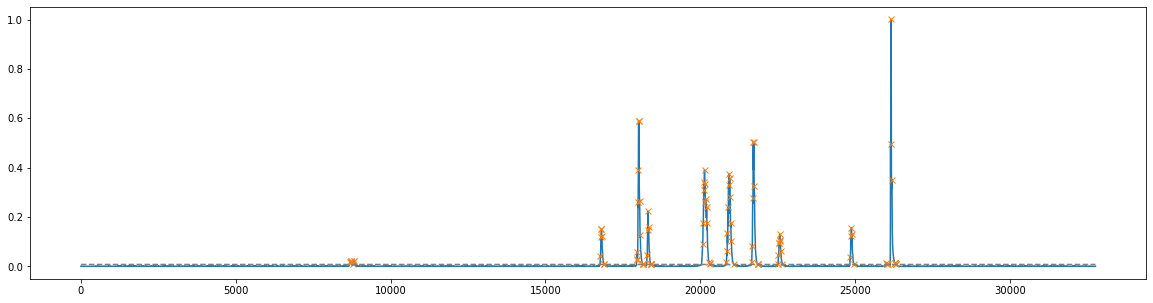

In [15]:
# Identifying spectral peaks and determining the height value
from scipy.signal import find_peaks
plt.figure(figsize= (20,5))
height = 0.008 
peaks, _ = find_peaks(data_raw, height=height)    
plt.plot(data_raw)
plt.plot(peaks, data_raw[peaks], "x")
plt.plot(np.zeros_like(data_raw) + height, "--", color="gray")
plt.show()

In [16]:
# Training the Model and obtaining vorrected spectra
import time
ti = time.time()
output_list = []
v_cut = 0.05
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for indx, ref_peak_pos in enumerate(ref_peak_pos_list):
    sim_data_f = np.zeros(data_raw.shape)
    per_data_l = np.zeros(data_raw.shape)
    per_data_s = per_data(ref_peak_pos)
    sim_template = data_raw[ref_peak_pos-100: ref_peak_pos+100]
    per_template = per_data_s[ref_peak_pos-100: ref_peak_pos+100]
    height = 0.01 
    peaks1, _ = find_peaks(data_raw[:ref_peak_pos-100], height=height)
    peaks2, _ = find_peaks(data_raw[ref_peak_pos+100:], height=height)
    for i in np.append(peaks1 , (peaks2+ref_peak_pos+100)): 
        sim_data_f[i-100: i+100] += sim_template*(data_raw[i] )  
        per_data_l[i-100: i+100] += per_template*(data_raw[i] ) 
    sim_data_f[ref_peak_pos-100: ref_peak_pos+100] = sim_template
    per_data_l[ref_peak_pos-100: ref_peak_pos+100] = per_template

    scal = max(sim_data_f.max(), per_data_l.max())
    X = sim_data_f/scal  
    y = per_data_l/scal 

    new_dataset = TensorDataset(torch.tensor(X).reshape(1,1,-1), torch.tensor(y).reshape(1,1,-1))
    train_loader = DataLoader(dataset=new_dataset, batch_size=1, shuffle=True)

    net = models_RHUnet.uNet8() 
    model = net.to(device).double()
    criterion = models_RHUnet.losss  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    per_fid = per_data(ref_peak_pos)
    per_fid = torch.tensor(per_fid).reshape(1,1,-1).to(device)
    data_14_2 = np.array(data_list)/np.array(data_list)[ref_peak_pos-100:ref_peak_pos+100].max() - down
    v_data_14 = torch.tensor(data_14_2).reshape(1,1,-1).to(device)
    loss_list = []
    v_list = []
    peak_list = []
    for epoch in range(0, 1000):
        for data, target in train_loader:
            X = data.double().to(device) 
            y = (target).to(device) 
            model.train()
            optimizer.zero_grad()               
            output = model(X )        
            loss = criterion(output, y)  
            loss = loss.double()
            loss.backward()                     
            optimizer.step()                    
            loss_list.append(loss.data)
            
        if epoch % 50 == 0:  
            optimizer.param_groups[0]['lr']*=0.9 
                
        output_n = model(v_data_14)    
        val_loss = models_RHUnet.losss_stop(output_n[:,:,ref_peak_pos-100:ref_peak_pos+100]/output_n[:,:,ref_peak_pos-100:ref_peak_pos+100].max(), per_fid[:,:,ref_peak_pos-100:ref_peak_pos+100])  
        v_list.append(val_loss.item())
        peak_list.append((output_n[:,:,ref_peak_pos-100:ref_peak_pos+100]/output_n[:,:,ref_peak_pos-100:ref_peak_pos+100].max()).squeeze().cpu().detach())
        
        if  val_loss <= v_cut:  
            print(val_loss.item(), 'GOOD! Training Done')
            output_list.append(output_n.squeeze().cpu().detach())
            break   
        
        print('Epoch[{}/{}/{}], \tloss: {:.6f}, \tval_loss: {:.6f}, '.format(indx, 1000,  epoch, loss.data*10000, val_loss)) 

    end_time = time.time()
    print('total time:{:.3f}s '.format(end_time-ti )) 


Epoch[0/1000/0], 	loss: 18.742836, 	val_loss: 2.025321, 
Epoch[0/1000/1], 	loss: 17.269530, 	val_loss: 2.058026, 
Epoch[0/1000/2], 	loss: 16.681485, 	val_loss: 2.057922, 
Epoch[0/1000/3], 	loss: 16.500320, 	val_loss: 2.052518, 
Epoch[0/1000/4], 	loss: 16.590413, 	val_loss: 2.041384, 
Epoch[0/1000/5], 	loss: 16.614586, 	val_loss: 2.025813, 
Epoch[0/1000/6], 	loss: 16.472575, 	val_loss: 2.007986, 
Epoch[0/1000/7], 	loss: 16.339401, 	val_loss: 1.996697, 
Epoch[0/1000/8], 	loss: 16.308181, 	val_loss: 1.972283, 
Epoch[0/1000/9], 	loss: 16.325399, 	val_loss: 1.923086, 
Epoch[0/1000/10], 	loss: 16.262533, 	val_loss: 1.908309, 
Epoch[0/1000/11], 	loss: 16.150115, 	val_loss: 1.898591, 
Epoch[0/1000/12], 	loss: 16.050410, 	val_loss: 1.879838, 
Epoch[0/1000/13], 	loss: 15.970138, 	val_loss: 1.831659, 
Epoch[0/1000/14], 	loss: 15.795513, 	val_loss: 1.761951, 
Epoch[0/1000/15], 	loss: 15.558972, 	val_loss: 1.711555, 
Epoch[0/1000/16], 	loss: 15.374054, 	val_loss: 1.734372, 
Epoch[0/1000/17], 	loss:

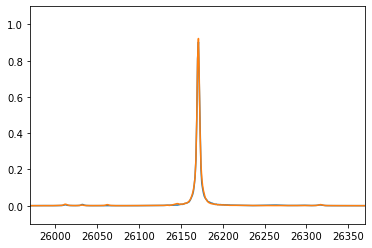

In [17]:
output_list_1 = output_list[0].numpy()
output_list_1_b = output_list[0].numpy()
delta_roll = ref_peak_pos2 - ref_peak_pos1
output_list_1roll = np.roll(output_list_1, delta_roll)  
plt.plot(output_list_1roll)
plt.plot(output_list[1].numpy())
plt.xlim(DSS_position-200, DSS_position+200) 
plt.ylim(-0.1, 1.1)
plt.show()

In [18]:
output_spec = (output_list_1roll*heights[b][0]+output_list[1].numpy()*heights[b][1])/heights[b].sum()
output_spec.shape

(32768,)

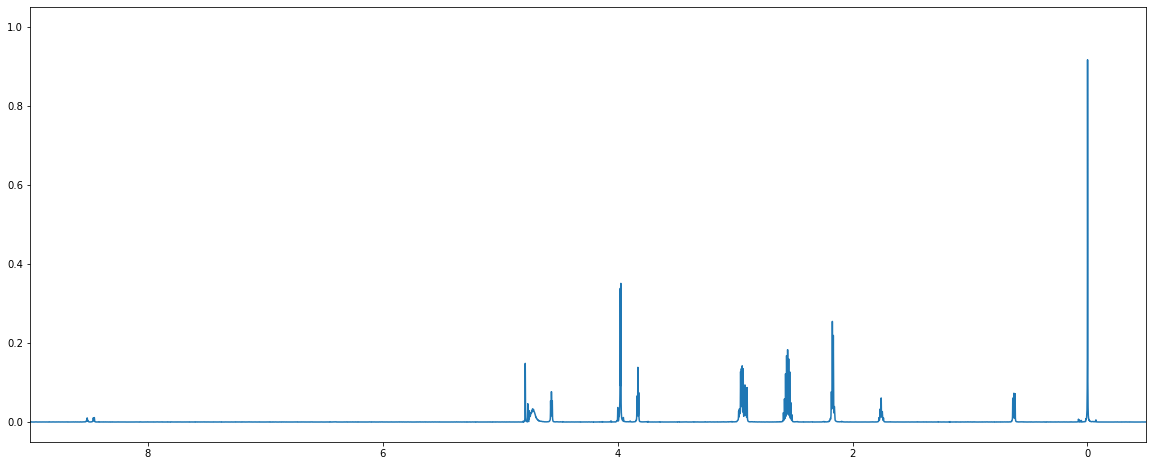

In [19]:
# Final Output Spectra
plt.figure(figsize=(20,8))
plt.plot(ppm, output_spec)
plt.xlim(9.0, -0.5)
plt.ylim(-0.05, 1.05)
plt.show()